## This notebook contains an example of how to do SDB with a Random Forest model, using point observations of depth and a Sentinel-2 image.
### The specific data used in this example are airborne lidar data from SHOM and a composite Sentinel-2 image. The same workflow would work with other similar data sets.
### To keep the file sizes small, only a subset of the original S2 image is used here.

### 1) Install and import needed packages

In [1]:
!pip install rasterio
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [26]:
import os

import numpy as np
import random

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

"""

import os.path
import math
import glob





import rasterio.plot



from matplotlib.pyplot import figure




from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import scipy


from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

"""

import warnings
warnings.filterwarnings('ignore')

### 2) Read the satellite image

#### This example imports a multi-band GeoTiff file containing the first five bands of a Sentinel-2 image. Other images, including those with a different number of bands, can be used with minor modifications of the code below.

#### Also note that the image used here has been resampled to 10-m resolution for all bands.

In [3]:
# Set the directory that holds your data
myDir = "C:/Users/aknudby/OneDrive - University of Ottawa/SDB/Corsica/"  
os.chdir(myDir)

# Read image as rasterio dataset
image_filename = "S2.tif"  ### Update image filename here ###
image_ds = rasterio.open(image_filename)

#### Plot the image to check that it loaded alright - colours will look wrong but that's ok, we're just checking that the data got loaded properly

<Axes: >

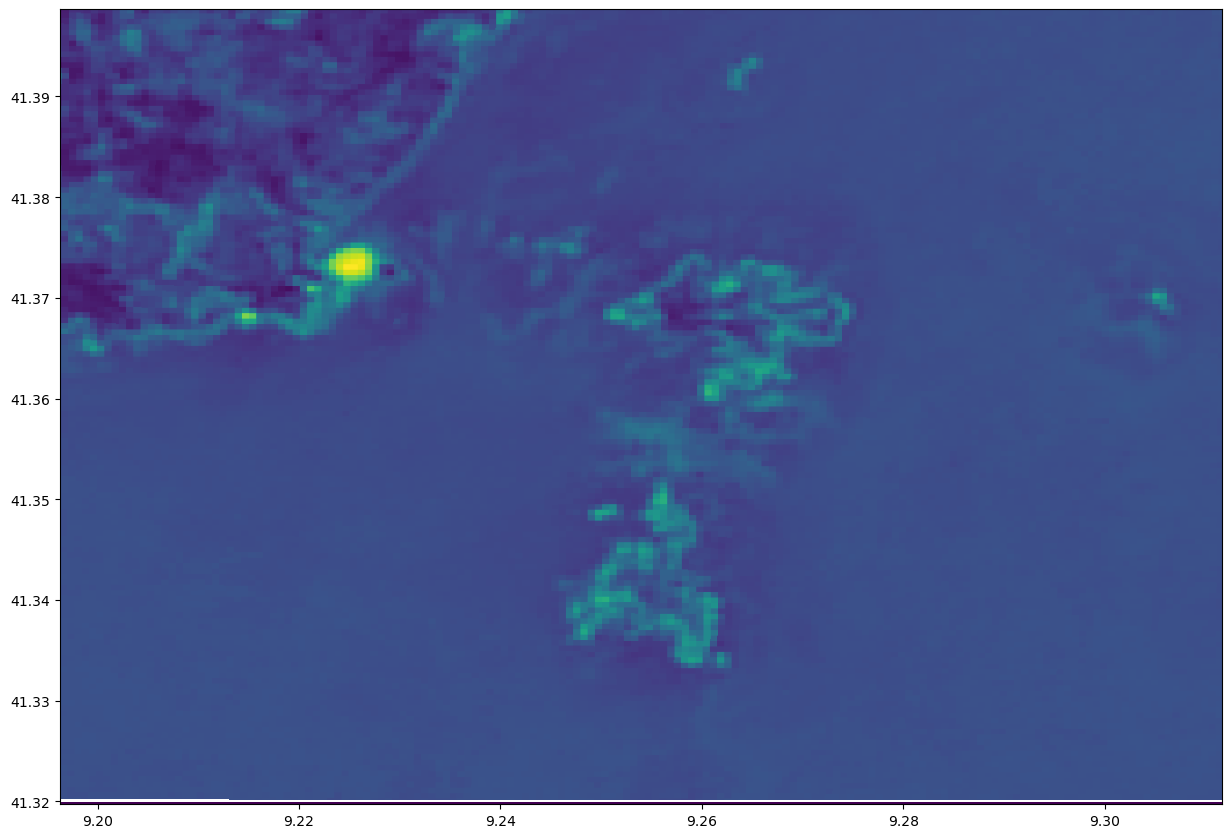

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
show(image_ds, ax=ax)

#### As mentioned above, this example uses the first five bands of a Sentinel-2 image. If your image uses a different number of bands, update accordingly here.

In [5]:
# Convert image bands to NumPy arrays
b1 = image_ds.read(1)
b2 = image_ds.read(2)
b3 = image_ds.read(3)
b4 = image_ds.read(4)
b5 = image_ds.read(5)

### 3) Load the point observations of depth

In [6]:
# Read the file as a geopandas dataframe, here I use a shapefile format
depth_file = myDir + "depth_data.shp"
df = gpd.read_file(depth_file) 

In [7]:
# Clean up data frame to only contain the necessary information. This may vary depending on the attributes in your data
columnsToRetain = ['depth', 'Id', 'geometry']
df = df.drop(columns=[col for col in df if col not in columnsToRetain])

#### If the coordinate systems of the two datasets are not identical, make the depth data match the system of the image

In [8]:
if df.crs != image_ds.crs:
    df  = df.to_crs(image_ds.crs)

In [9]:
# Check that the data make sense
print(df.head())

    Id  depth                  geometry
0  212   0.32  POINT (9.24000 41.39754)
1  212   1.69  POINT (9.24012 41.39754)
2  212   2.26  POINT (9.24024 41.39754)
3  212   2.72  POINT (9.24036 41.39754)
4  212   3.10  POINT (9.24048 41.39754)


### 4) Sample the image bands using the points from the shapefile

In [10]:
### If you changed the bands above, you must also change them here ###

coords = [(x,y) for x, y in zip(df['geometry'].x, df['geometry'].y)]
df['b1'] = [x[0] for x in image_ds.sample(coords, indexes=1)]
df['b2'] = [x[0] for x in image_ds.sample(coords, indexes=2)]
df['b3'] = [x[0] for x in image_ds.sample(coords, indexes=3)]
df['b4'] = [x[0] for x in image_ds.sample(coords, indexes=4)]
df['b5'] = [x[0] for x in image_ds.sample(coords, indexes=5)]

In [11]:
# Check that columns have been added that contain the information from the imagery
print(df.head())

    Id  depth                  geometry      b1      b2      b3      b4  \
0  212   0.32  POINT (9.24000 41.39754)  0.0832  0.1438  0.1638  0.1586   
1  212   1.69  POINT (9.24012 41.39754)  0.0832  0.1042  0.1152  0.0675   
2  212   2.26  POINT (9.24024 41.39754)  0.0832  0.1042  0.1152  0.0675   
3  212   2.72  POINT (9.24036 41.39754)  0.0696  0.0747  0.0797  0.0236   
4  212   3.10  POINT (9.24048 41.39754)  0.0696  0.0543  0.0565  0.0176   

       b5  
0  0.1160  
1  0.1160  
2  0.1160  
3  0.0090  
4  0.0133  


### 5) Do a bit of cleanup

#### Remove any points that fall outside the image; these will have values of 0 in all bands. Also remove any points that have NoData in any of the bands

In [12]:
# Remove any points outside the image (i.e. points with zero in all bands)
df = df.drop(df[(df['b1'] == 0.0) & (df['b2'] == 0.0) & (df['b3'] == 0.0) & (df['b4'] == 0.0) & (df['b5'] == 0.0)].index)

# Also remove any points with NaN in any band
df.dropna()

,Id,depth,geometry,b1,b2,b3,b4,b5
0,212,0.32,POINT (9.24000 41.39754),0.0832,0.1438,0.1638,0.1586,0.1160
1,212,1.69,POINT (9.24012 41.39754),0.0832,0.1042,0.1152,0.0675,0.1160
2,212,2.26,POINT (9.24024 41.39754),0.0832,0.1042,0.1152,0.0675,0.1160
3,212,2.72,POINT (9.24036 41.39754),0.0696,0.0747,0.0797,0.0236,0.0090
4,212,3.10,POINT (9.24048 41.39754),0.0696,0.0543,0.0565,0.0176,0.0133
...,...,...,...,...,...,...,...,...
165706,17,18.76,POINT (9.25836 41.32022),0.0343,0.0289,0.0182,0.0112,0.0117
165707,17,19.05,POINT (9.25848 41.32022),0.0343,0.0289,0.0182,0.0112,0.0117
165708,17,18.87,POINT (9.25860 41.32022),0.0340,0.0290,0.0191,0.0115,0.0117
165709,18,18.54,POINT (9.25871 41.32022),0.0340,0.0282,0.0178,0.0109,0.0117


#### Depending on the density of points and the spatial resolution of the image, you may end up with multiple points in each pixel. This bit of code checks for that, and creates a single point for any pixel that has multiple points in it, that point having the mean depth value of the original points.

In [13]:
# Add the coordinates for each point columns in the dataframe
df['x'] = df.geometry.x
df['y'] = df.geometry.y
df = df.drop('geometry', axis=1)

In [14]:
# Retain mean depth values when there are multiple points in each pixel
df = df.groupby(['b1', 'b2', 'b3', 'b4', 'b5']).mean().reset_index()

In [15]:
print(df.head())

      b1      b2      b3      b4      b5     Id  depth         x          y
0  0.006  0.0080  0.0166  0.0178  0.0234  127.0   0.17  9.218857  41.370831
1  0.006  0.0089  0.0163  0.0172  0.0242  127.0   0.15  9.218737  41.370831
2  0.006  0.0100  0.0166  0.0147  0.0242  127.0   0.15  9.218618  41.370832
3  0.006  0.0101  0.0160  0.0176  0.0234  127.0   0.17  9.218977  41.370921
4  0.006  0.0102  0.0151  0.0155  0.0279  127.0   0.13  9.218618  41.371012


In [16]:
# Convert Id back into integer
df['Id'] = df['Id'].astype(int)

### 6) Do SDB with Random Forest

#### Ok, now we're ready to make the random forest model.

#### To conduct a test of how good any model is at making predictions for new data - which is what we typically want models to be able to do - we need to make sure that we test the model against data that are "independent" from the data it is trained on.

#### "Independence" is a rather complex concept, and is probably better thought of as a relative than an absolute term. When working with spatial data, we can typically consider spatial proximity to be a good proxy for independence (closer data points being less independent from each other), so we want to make sure that the data used to train the model, and the data used to test the model, are as far away from each other as possible, within reason.

#### To that effect, we have predesigned a grid and assigned the grid ID to each point. That way at least we can take training data from a random sample of grid squares and make sure that the test data are from different grid squares. For more information on this, see Fig. 2 here: https://www.sciencedirect.com/science/article/pii/S2352938523001155

#### Create training and testing data

In [17]:
# List the different IDs
IDs = set(df['Id'])
print(IDs)

{128, 129, 130, 131, 132, 133, 138, 17, 18, 145, 155, 156, 157, 158, 159, 160, 161, 44, 45, 46, 184, 185, 186, 59, 198, 73, 74, 75, 212, 213, 214, 88, 97, 98, 101, 102, 103, 110, 114, 125, 126, 127}


In [18]:
# Randomly select 70% of the IDs for the training data
trainingProportion = 0.7
trainingIDs = list(set(random.sample(IDs, int(len(IDs) * trainingProportion))))
print("Training IDs: ", trainingIDs)

# And make the rest of the IDs test data
testingIDs = list(set(IDs) - set(trainingIDs))
print("Testing IDs: ", testingIDs)

Training IDs:  [128, 129, 131, 145, 18, 155, 156, 157, 158, 159, 161, 45, 46, 185, 186, 198, 73, 74, 213, 214, 88, 98, 101, 102, 103, 110, 114, 125, 126]
Testing IDs:  [160, 97, 130, 132, 133, 138, 75, 44, 17, 212, 184, 59, 127]


In [19]:
# Now that the IDs are separated, allocate the data associated with each ID to the training and testing sets
training = df.loc[df['Id'].isin(trainingIDs)]
testing = df.loc[df['Id'].isin(testingIDs)]

In [20]:
# As you probably saw above, there are LOTS of data in this data set. Just to make things run a bit faster below,
# let's subsample both the training and the testing data a bit. You can ignore this code block, or set n to a larger value,
# if you want to improve model performance at the expense of computing time.

training = training.sample(n = 1000)
testing = testing.sample(n = 1000)

#### Train the Random Forest model. A few notes:
#### Any other type of predictive model could be used here.
#### Normally you should optimize ("tune") model parameters for any machine learning model. Because this is a quick demonstration and parameter tuning can take a while, it is not included here.

In [21]:
# Here we will just use parameters that I have found to work well, generally, and
# won't take too long to run for this data set.

# Set model parameters
n_estimators = 30
max_features = 'log2'
criterion = "absolute_error"
columns = ["depth", "pred"]

# Calibrate the Random Forest model using the training data
X = np.dstack((training["b1"], training["b2"], training["b3"], training["b4"], training["b5"]))[0, :, :]
y = training["depth"]
reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, criterion=criterion)
reg.fit(X, y)

RandomForestRegressor(criterion='absolute_error', max_features='log2',
                      n_estimators=30)

#### Now use the trained model to make predictions for the testing data

In [22]:
newX = np.dstack((testing["b1"], testing["b2"], testing["b3"], testing["b4"], testing["b5"]))[0, :, :]
testing["pred"] = reg.predict(newX)

#### To see how good the model was at predicting the depths of the testing data using the image-derived pixel values, let's look at a scatter plot, and also calculate the R2 and mean absolute error (MAE) values

Pearson's correlation: 0.93
MAE: 1.70


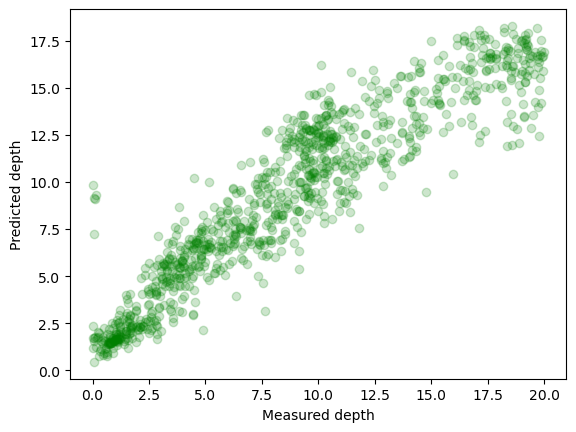

In [23]:
corr, _ = pearsonr(testing["pred"], testing["depth"])
print("Pearson's correlation: %.2f" % corr)

testing["error"] = testing["pred"] - testing["depth"]
testing["abs_error"] = np.abs(testing["error"])
mae_total = np.mean(testing["abs_error"])

print("MAE: %.2f" % mae_total)

plt.scatter(testing["depth"], testing["pred"], c="g", alpha=0.2)
plt.xlabel("Measured depth")
plt.ylabel("Predicted depth")
plt.show()

#### Because this kind of SDB only works where sunlight reflecting off the seafloor has a detectable influence on the signal measured by the satellite, the prediction errors generally increase with depth. It therefore often makes sense to report not just one error value (such as the MAE value above), but to report the errors for different depths separately.

In [37]:
### Disaggregate error stats by depth range ###

# Determine min and max depth predictions for the testing data
min_depth = testing['pred'].min()
max_depth = testing['pred'].max()
min_depth_rounded = int(np.floor(min_depth))
max_depth_rounded = int(np.ceil(max_depth))

# Create some lists to hold results
mindepth = [] # This will hold the lower bound depth value of the interval
maxdepth = [] # Same, upper bound
mae = [] # MAE for the interval

for j in range(min_depth_rounded, max_depth_rounded, 1):  # Using 1-m depth intervals here
  
  df = testing[testing['pred'].between(j, j+1, inclusive='right')]
  errors = (df['depth'] - df['pred']).tolist()
  meanabserror = np.mean(np.abs(errors))
  mindepth.append(j)
  maxdepth.append(j+1)
  mae.append(meanabserror)

# Put all error results into a dataframe
errors_by_depth = pd.DataFrame(
    {'Min. Depth': mindepth,
     'Max. Depth': maxdepth,
     'MAE': mae
    })

print(errors_by_depth)

    Min. Depth  Max. Depth       MAE
0            0           1  0.289292
1            1           2  0.733151
2            2           3  0.822557
3            3           4  1.096611
4            4           5  1.274739
5            5           6  1.624761
6            6           7  1.486488
7            7           8  1.743181
8            8           9  1.449852
9            9          10  2.006891
10          10          11  1.407271
11          11          12  1.878708
12          12          13  2.672601
13          13          14  2.826918
14          14          15  2.263530
15          15          16  2.280503
16          16          17  1.920383
17          17          18  1.164767
18          18          19  0.699208


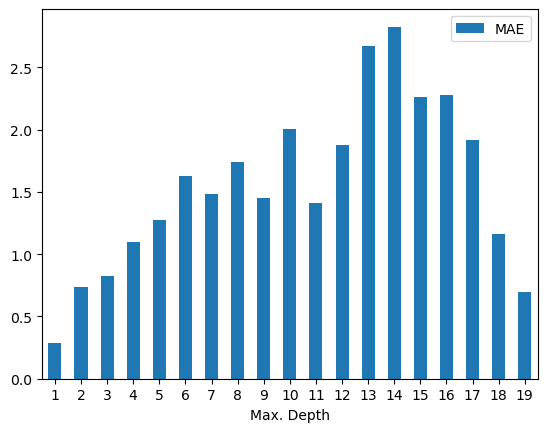

In [36]:
# Or show the errors on a bar plot
ax = errors_by_depth.plot.bar(x='Max. Depth', y='MAE', rot=0)

### 7) The final step is to use the model to make predictions for all pixels in the image

#### To work with predictions, we need to flatten the 2D image bands into 1D NumPy arrays, then pass them all through the model, and the "unflatten" them again to recreate the correct image geometry

In [38]:
# To work with predictions, we need to flatten the input arrays
# Because some images contain NoData values in the corners, we also turn those into zeros
b1_flat = np.nan_to_num(b1.flatten())
b2_flat = np.nan_to_num(b2.flatten())
b3_flat = np.nan_to_num(b3.flatten())
b4_flat = np.nan_to_num(b4.flatten())
b5_flat = np.nan_to_num(b5.flatten())

# Restructure the data to work with the "predict" function
newX = np.dstack((b1_flat, b2_flat, b3_flat, b4_flat, b5_flat))[0, :, :]

# Make the preditions for each pixel
new_predictions = reg.predict(newX)

# "Unflatten" the result
new_predictions_unflattened = new_predictions.reshape(b1.shape)

In [40]:
# Write predictions to file
predictions_filename = myDir + "SDB.tif"

with rasterio.Env():

    # Write an array as a raster band to a new file. For the new file's profile, we start with the profile of the source
    profile = image_ds.profile

    # Then set the dtype to contain floats, and specify LZW compression.
    profile.update(
        driver='GTiff',
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open(predictions_filename, 'w', **profile) as dst:
        dst.write(new_predictions_unflattened.astype(rasterio.float32), 1)
        dst.set_band_description(1, 'SDB')

### 8) Important notes:

#### The code shown above makes SDB predictions of water depth for all pixels in the image. These predictions are not meaning for pixels on land, and neither are they meaningful for water that is optically deep, i.e. where sunlight reflected off the seafloor has a non-detectable influence on the colour of the pixel. It is therefore up to the user to mask out those pixels from the result.
#### Land pixels can often be masked out with a simple threshold applied to a near-infrared band. Optically deep pixels are more difficult to mask out, one way of doing this is to use the tool available here: https://github.com/yulunwu8/Optically-Shallow-Deep.
#### Finally, note that SDB predictions are just that - predictions. As shown above there are errors asociated with these predictions, and they should be used with appropriate caution.